In [1]:
%load_ext autoreload
%cd /Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/handmodelling_ciss17
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import preprocessing.Pipelines as pipelines
import preprocessing.Representations as reps

import models.AutoEncoder as autoenc
import models.AutoEncoderQuat as autoencquat

from keras.objectives import mean_squared_error as mse_loss 
from models.objectives.QuaternionLoss import QuaternionLoss

import visualisations.VisAutoEncoder as vis
import preprocessing.Metadata as meta

import analysis.AutoEncoderEvaluation as ae_eval

import tools.SummerSchoolTools as summer_school_help


data_filepath = 'data/aalto_metronome.csv'
model_storage_path = 'export/models/'

/Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/handmodelling_ciss17


/Users/rodmurraysmith/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
libraries/transformations.py:1913: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)
Using Theano backend.


# Load the data

In [2]:
data_raw = pipelines.load_aalto_hand_data(data_filepath)

Loaded 79150 rows with 85 columns from file:
data/aalto_metronome.csv
There are no missing values in this file.


# Preprocess the data

We prepare the data in two representations:
- as x, y, z coordinates
- as quaternions on a graph

In [3]:
data_quat = pipelines.preprocess_aalto_hand_data(
    data_raw, 
    representation=reps.REPRESENTATION_QUAT)

1. Added an origin column "Wrist_Origin" based on the mean of these columns: ['MetroArm_W_In', 'MetroArm_W_out']
2. Shifted the x/y/z coordinates so that they are relative to the origin column.
3. Merged the two hand center points.
4. Removed the original two hand center points.
5. Removed the extra arm points (E).
6. Converted the data from x/y/z coordinates to quaternion representation (i.e. quaternion and distance per joint along skeleton graph)
7. Reordered columns: non-feature columns first, then feature columns in order as specified in the metadata (see Metadata.py).
8. Removed the timestamp column ("Time"), leaving 128 columns.


## Split into training and test set

In [4]:
def split_train_test(data, ratio=0.75):
    N = len(data)
    split = int(ratio*N)
    data_train = data.iloc[:split]
    data_test = data.iloc[split:]
    return data_train, data_test

In [5]:
data_quat_train, data_quat_test = split_train_test(data_quat, ratio=0.75)

# Create an auto encoder (quaternion representation)

In [6]:
# You can switch between training with this loss and mse_loss and compare the results:
quat_loss = QuaternionLoss().loss 

ae_quat = autoencquat.AutoEncoderQuat(
    coding_dims=[128, 64, 8], 
    noise=0,
    dropout=[0,0,0],
    dropout_inputs=0,
    loss=quat_loss,
    batch_size=100,
    name_tag='ae_quat')
ae_quat.model_ae.summary()

models/AutoEncoder.py:152: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{a..., inputs=/input)`
  self.model_ae = Model(input=inputs, output=model_outputs)
models/AutoEncoder.py:104: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Elemwise{a..., inputs=/input)`
  output=self.model_ae.get_layer('encoded_drop').output)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 103)               0         
_________________________________________________________________
input_noise (GaussianNoiseHa (None, 103)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 103)               412       
_________________________________________________________________
encoded_0 (Dense)            (None, 128)               13312     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
encoded_0_act (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
encoded_0_drop (Dropout)     (None, 128)               0         
__________

## Run training

Train on 59362 samples, validate on 19788 samples
Epoch 1/10
59362/59362 [==============================] - 5s - loss: 9.4280 - val_loss: 6.9561

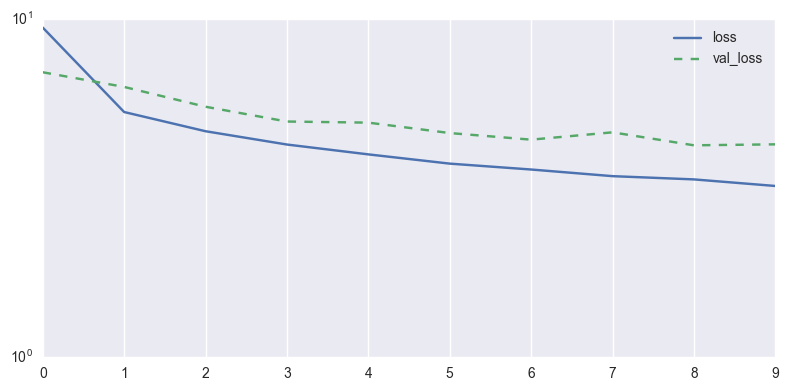

In [7]:
ae_quat.learning_rate = 0.001 
#if you change the learning rate, you must run training with recompile=True
ae_quat.train_epochs(
    data=data_quat_train.values,
    validation_data=data_quat_test.values,
    epochs=10, repetitions=1,
    path=model_storage_path,
    clear_history=False,
    recompile=False)
ae_quat.plot_history(offset=0)

### or run the cell below to load an existing model

In [8]:
ae_quat.load_from_file(model_storage_path + ae_quat.model_name + '.h5')

# Visualisations

## Hand posture reconstruction

In [9]:
summer_school_help.print_bone_names() #  run to see bone names to be used below
# t = thumb, i = index finger, m = middle finger, r = ring finger, l = little finger

arm_in
arm_out
centre
i1
i2
i3
i4
l1
l2
l3
l4
m1
m2
m3
m4
origin
r1
r2
r3
r4
t1
t2
t3
t4
wrist_in
wrist_out


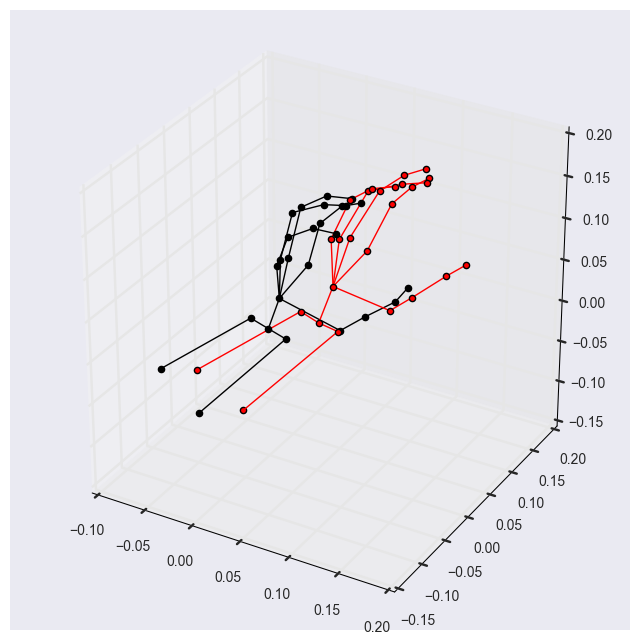

In [22]:
%autoreload 2
%matplotlib inline
vis.plot_compare_reconstructed_posture(
    data=data_quat_test, 
    metadata=meta.aalto_hand_data, 
    model=ae_quat, 
    frames=[1000], 
    dropout_features=None,
    dropout_inputs=0,
    representation=reps.REPRESENTATION_QUAT)

## Learned latent dimensions

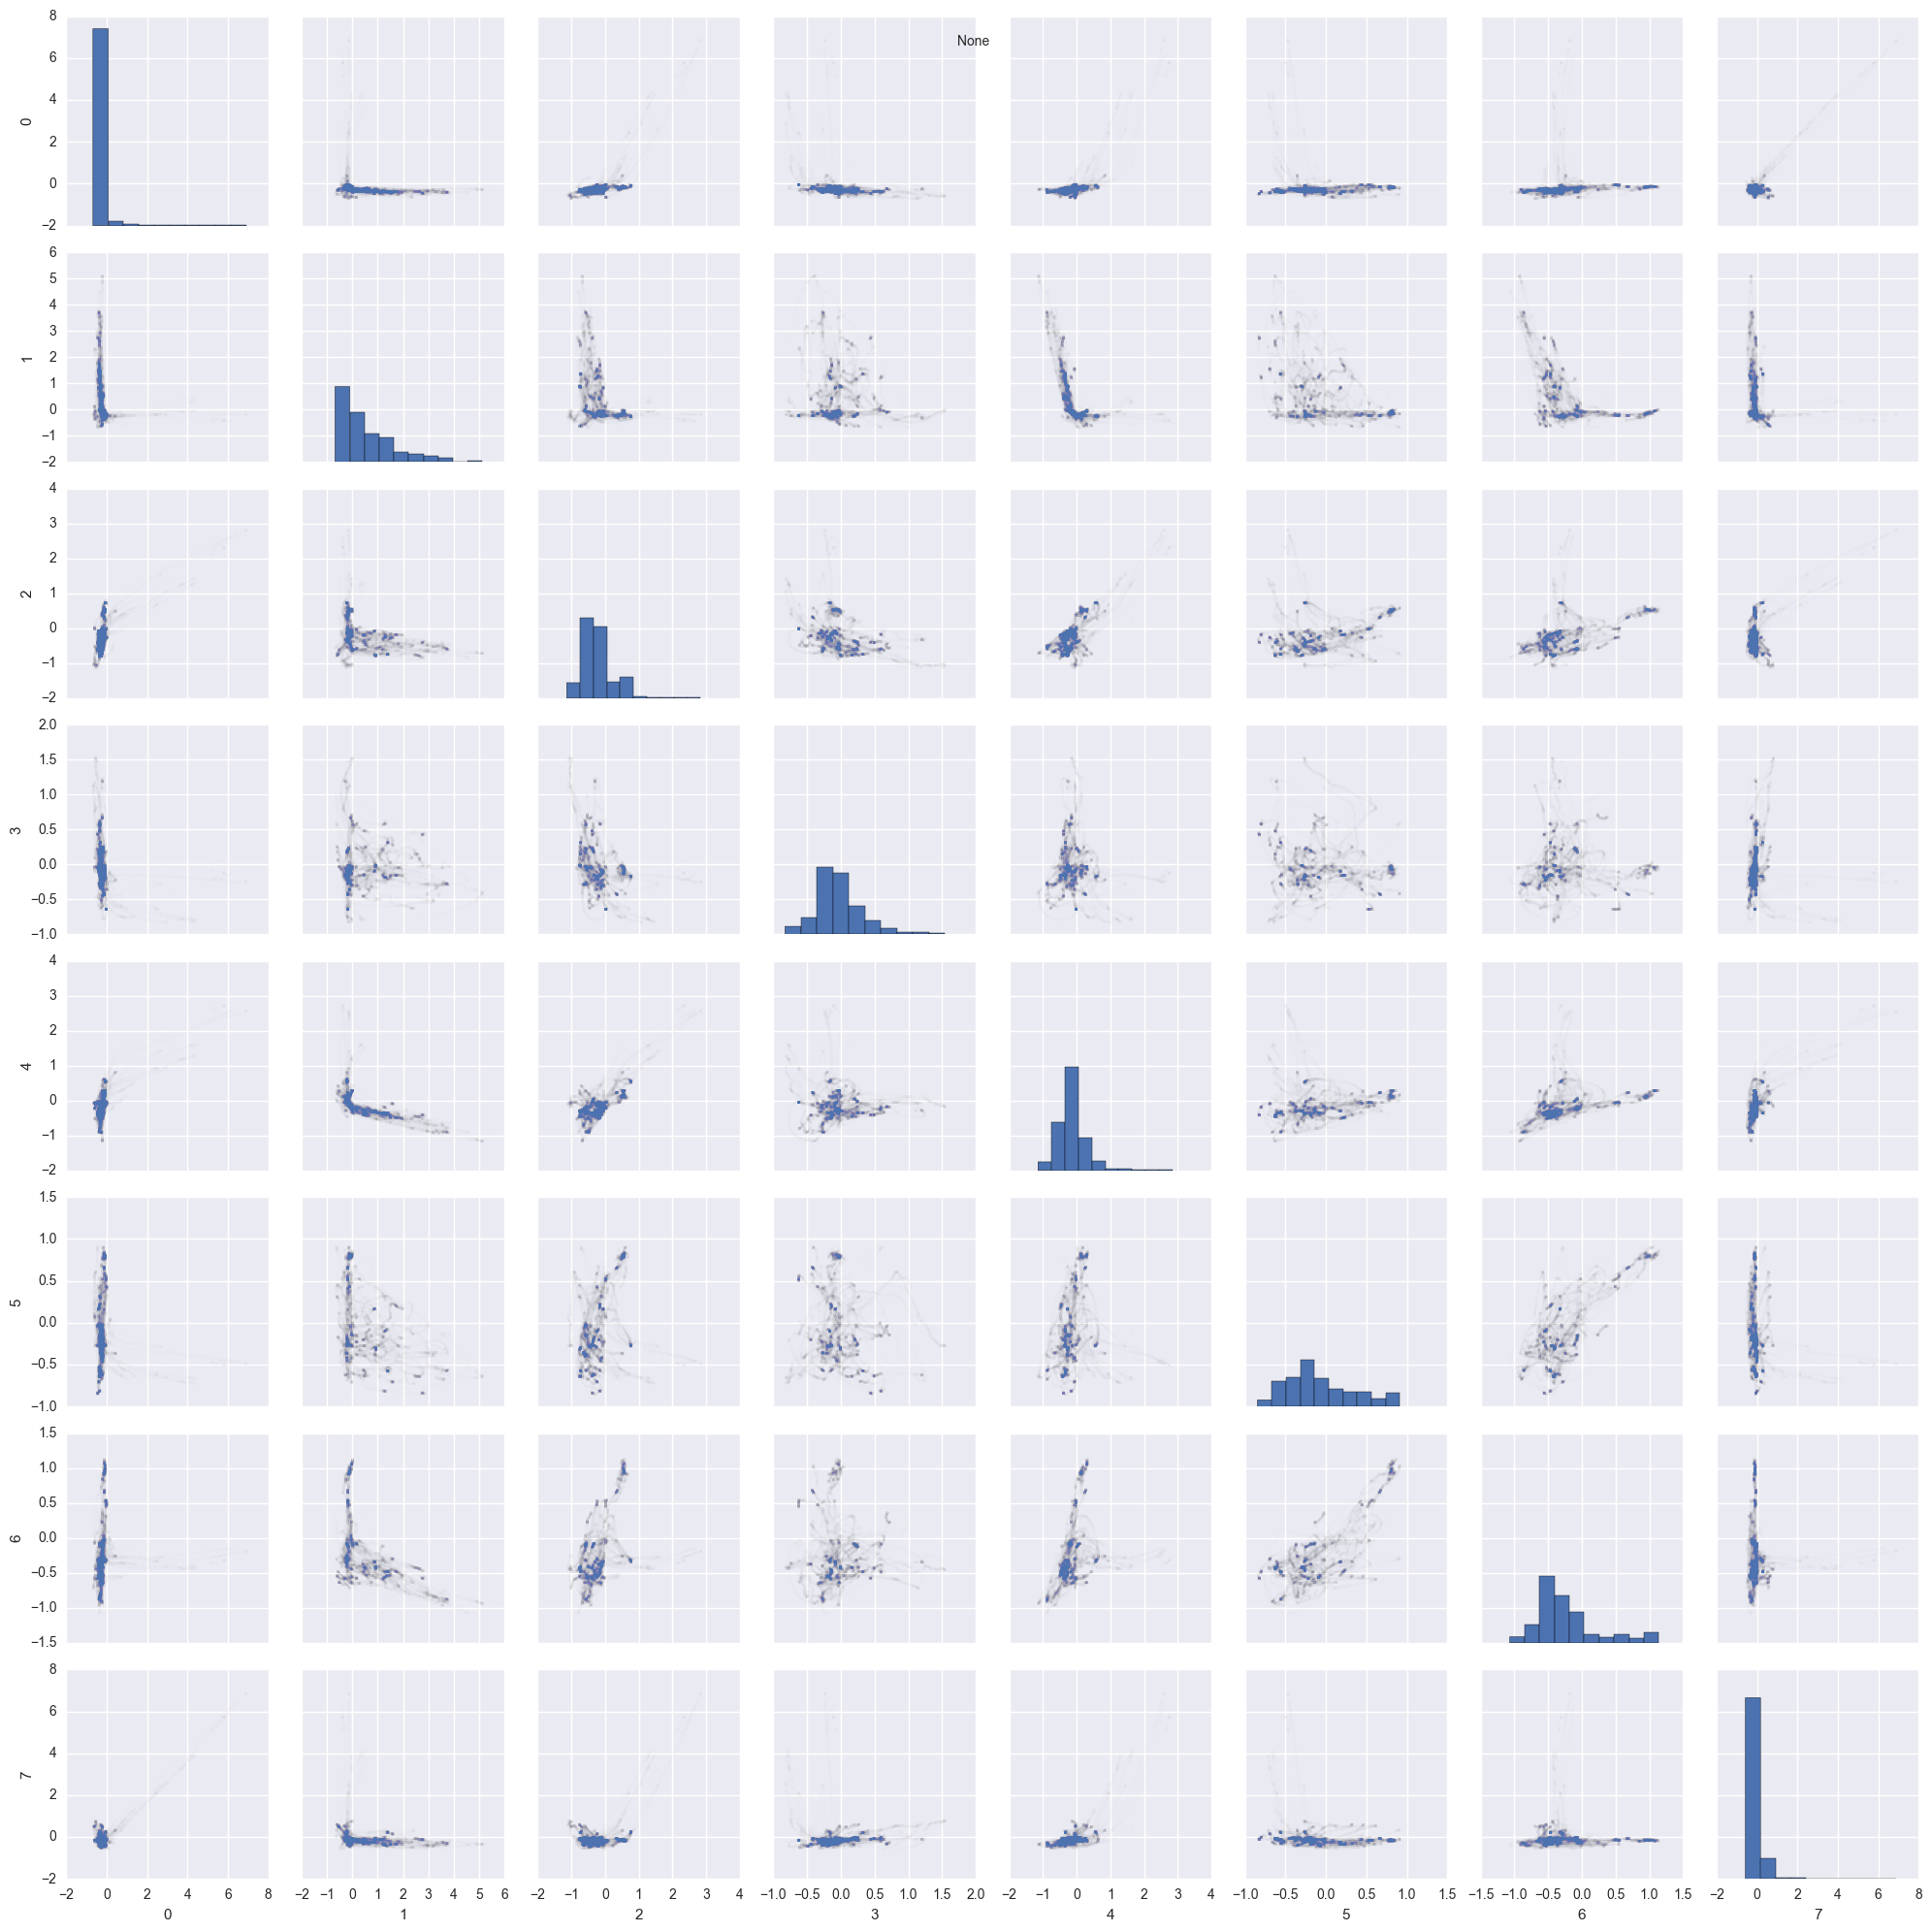

In [19]:
vis.plot_hand_data_latent_space_ND(
    data_quat_test.values, 
    ae_quat, 
    alpha=0.005, lw=0, s=5)

## Postures in learned latent dimensions

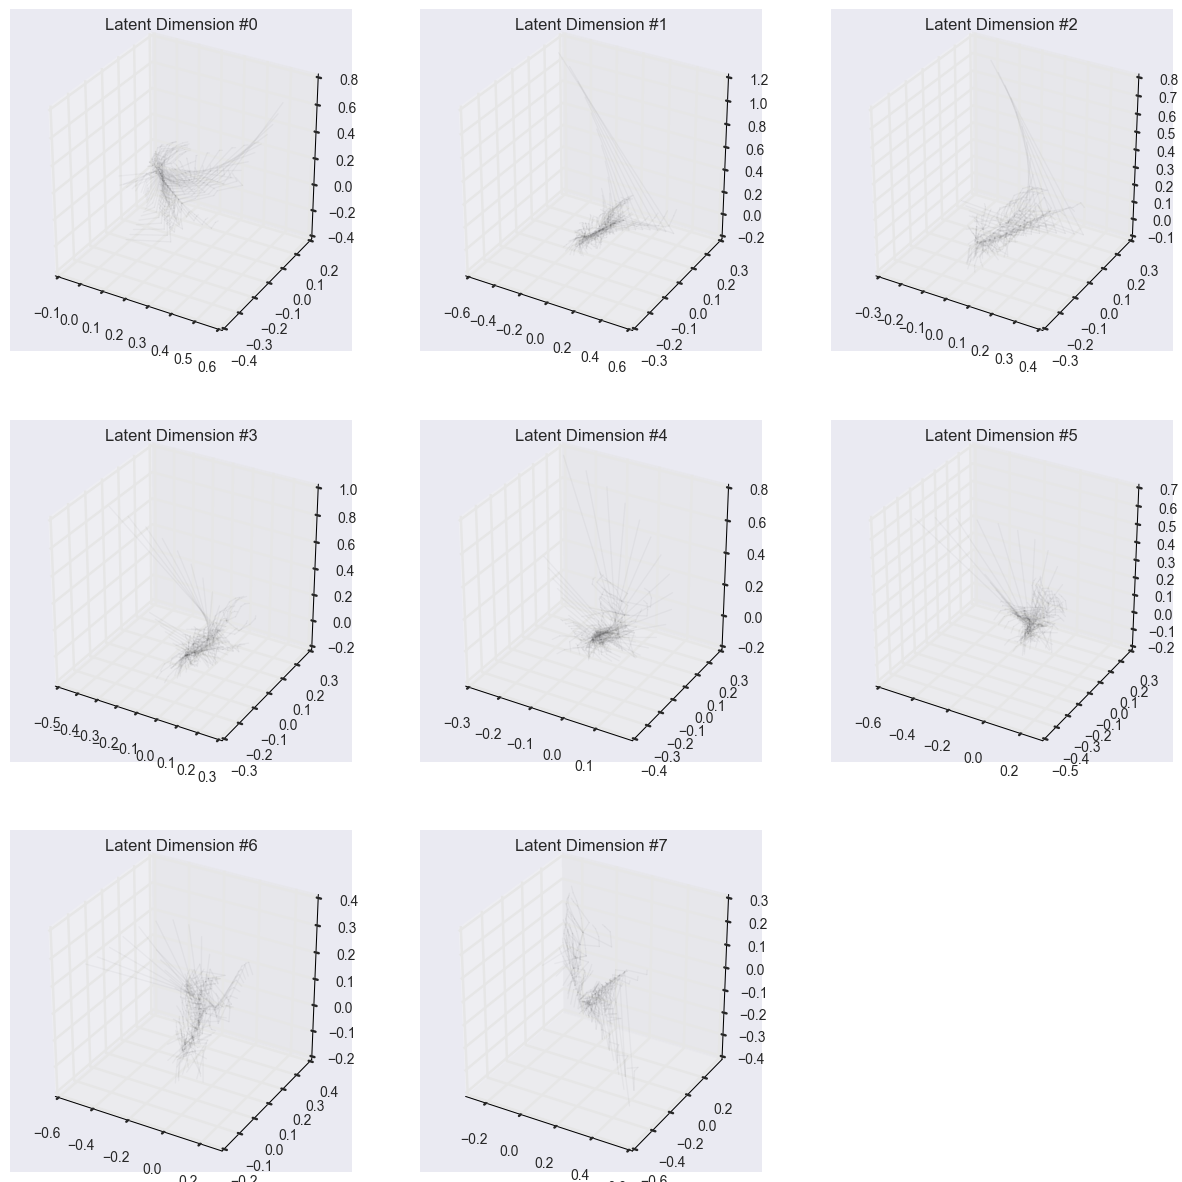

In [20]:
vis.plot_latent_dimensions(
    model=ae_quat,
    data=data_quat_test,
    metadata=meta.aalto_hand_data,
    steps=20,
    frame=1000,
    plot_static=True, plot_dynamics=False, verbose=False, 
    representation=reps.REPRESENTATION_QUAT)

## Posture 'derivatives' in learned latent dimensions

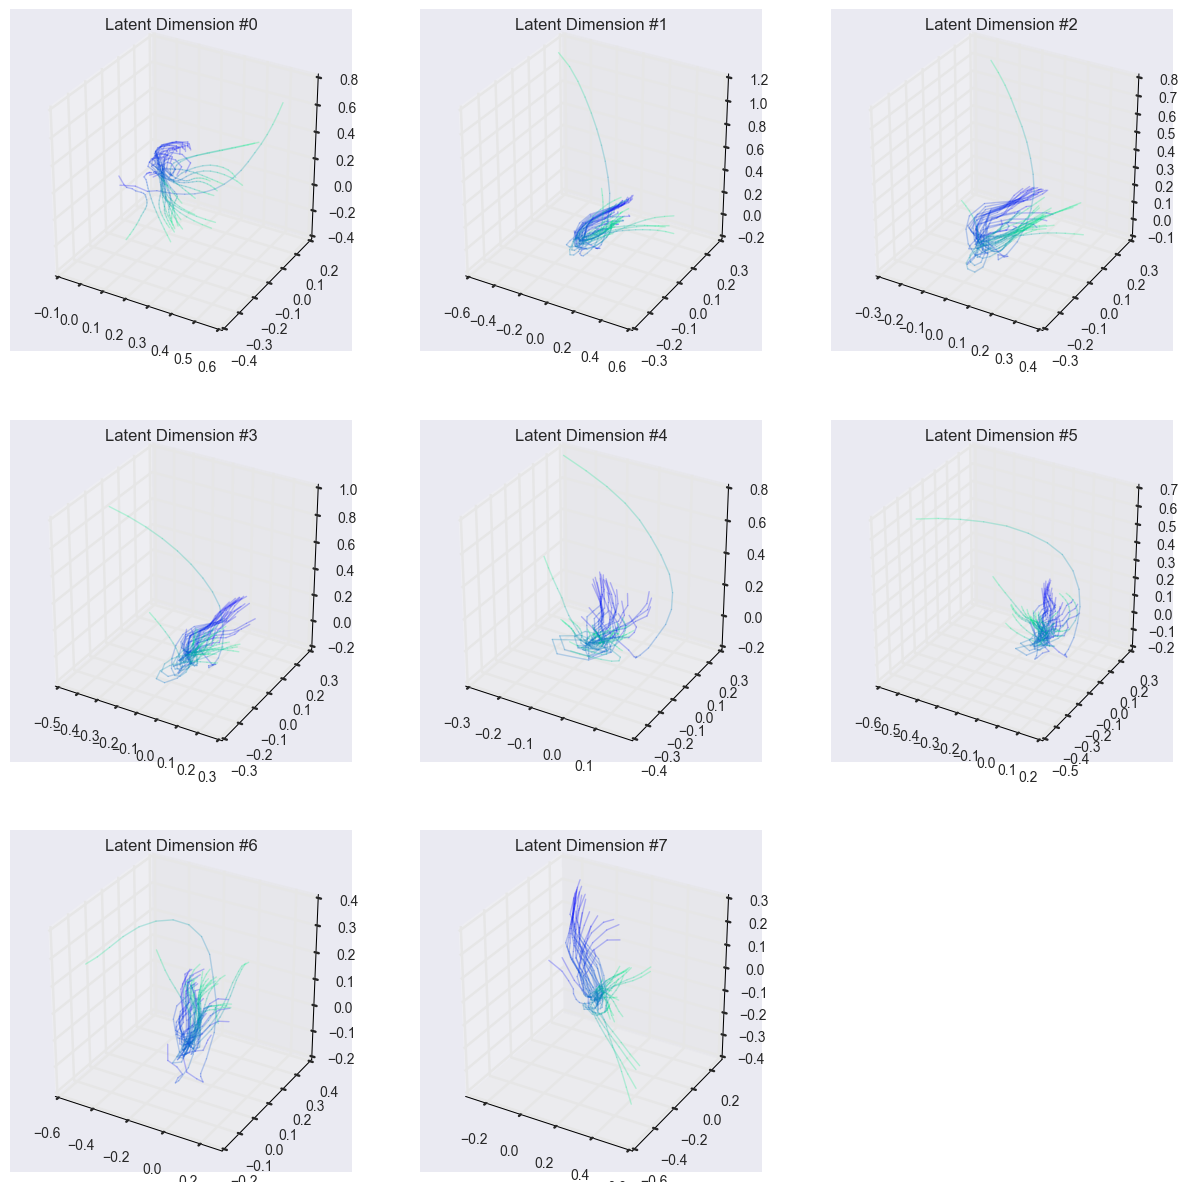

In [21]:
vis.plot_latent_dimensions(
    model=ae_quat,
    data=data_quat_test,
    metadata=meta.aalto_hand_data,
    steps=20,
    frame=1000,
    plot_static=False, plot_dynamics=True, verbose=False, 
    representation=reps.REPRESENTATION_QUAT)

## Interactive plots

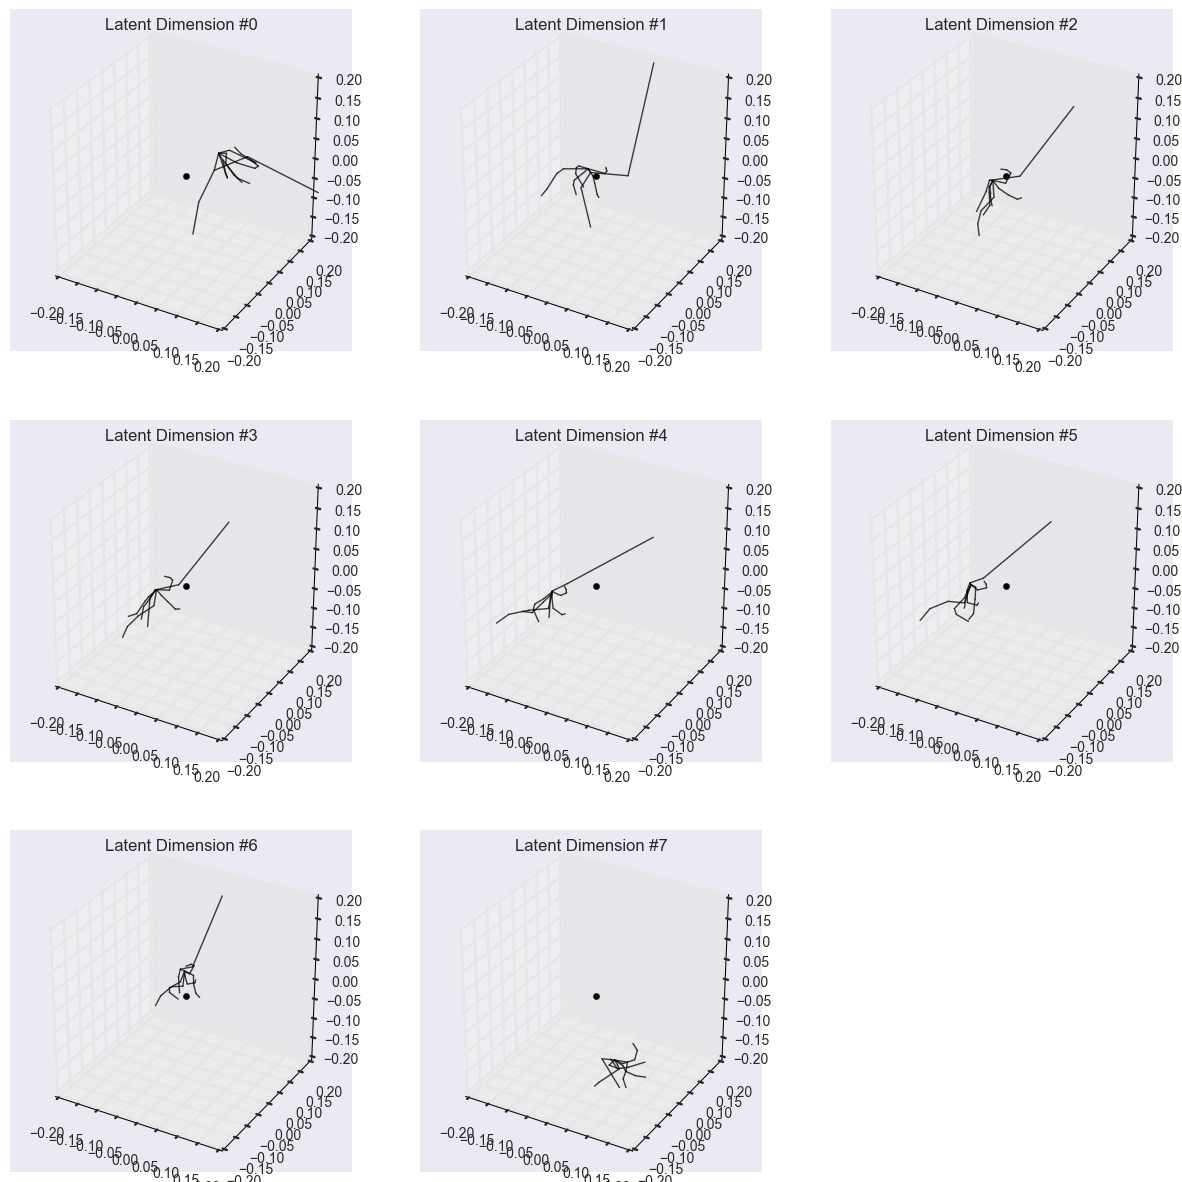

In [14]:
%matplotlib inline
vis.int_plot_latent_dimensions(
    model=ae_quat,
    data=data_quat_test,
    metadata=meta.aalto_hand_data,
    steps=20,
    frame=1000,
    representation=reps.REPRESENTATION_QUAT)

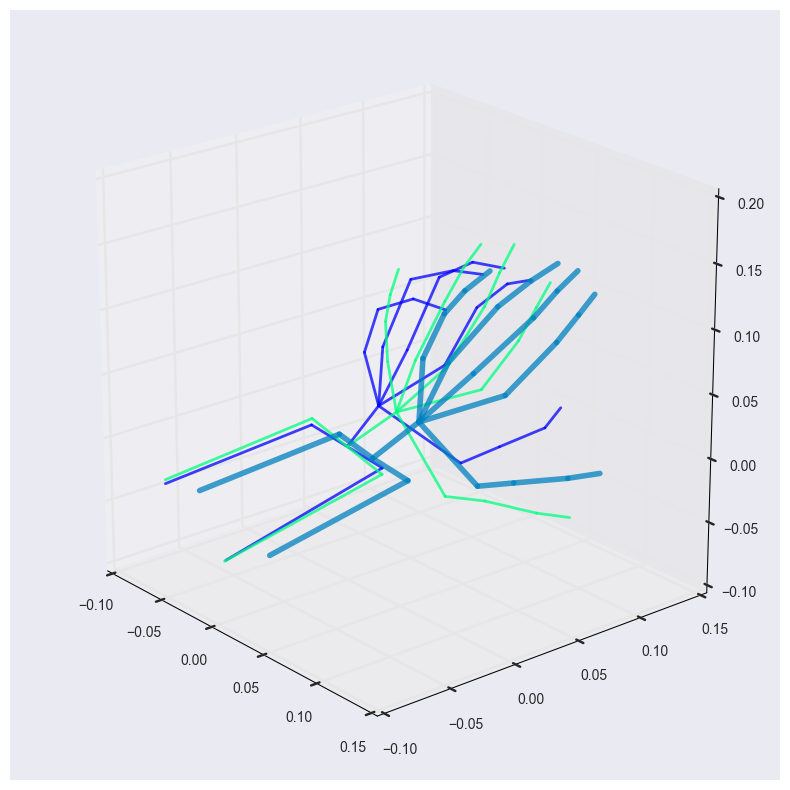

In [15]:
%matplotlib inline
vis.int_plot_interpolate_latent_space(
    model=ae_quat,
    data=data_quat_test,
    metadata=meta.aalto_hand_data,
    frame1=1000,
    frame2=2000,
    steps=20,
    representation=reps.REPRESENTATION_QUAT)

# Evaluation

In [16]:
ae_eval.compute_mse(
    model=ae_quat, 
    data=data_quat_test, 
    metadata=meta.aalto_hand_data,
    input_representation=reps.REPRESENTATION_QUAT,
    output_representation=reps.REPRESENTATION_QUAT,
    measure_representation=reps.REPRESENTATION_QUAT)

0.0029260152096335359

In [17]:
ae_eval.compute_quat_mse(
    model=ae_quat, 
    data=data_quat_test, 
    metadata=meta.aalto_hand_data,
    input_representation=reps.REPRESENTATION_QUAT,
    output_representation=reps.REPRESENTATION_QUAT)

23.380804984914967